# LSTM
## Using stock data of 60 days to predict

In [1]:
# install pakages
# pip install finance-datareader, tqdm, ...
! pip -q install --upgrade pip
! pip --disable-pip-version-check -q install bs4
! pip --disable-pip-version-check -q install finance-datareader
! pip --disable-pip-version-check -q install tqdm
! pip --disable-pip-version-check -q install matplotlib
# install torch
! pip --disable-pip-version-check -q install torch --extra-index-url https://download.pytorch.org/whl/cu113

# Data Processing

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from tqdm import tqdm

In [3]:
# open stock data
path = './open'
list_name = 'stock_list.csv'
sample_name = 'sample_submission.csv'

In [4]:
# print stock data by code
stock_list = pd.read_csv(os.path.join(path,list_name))
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))

In [5]:
# 전역변수
# 60일의 일일 종가를 기준으로 예측
predict_days = 60

# 입력값 설정
features = ['Open','Low','High','Close'] # 종가 가져오기
norm_factors = {'Open':1e6,'Low':1e6,'High':1e6,'Close':1e6} # 100만으로 나누기

In [6]:
# 주식 가격 가져오는 메소드
def get_data(code, start_date, end_date):
    stock_data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
    # 토요일, 일요일 제거, Business day로 expand
    business_days = pd.DataFrame(pd.date_range(start_date, end_date, freq='B'), columns = ['Date'])
    stock_data = pd.merge(business_days, stock_data, how = 'outer')
    # Nah를 그 전 종가로 채움
    stock_data = stock_data.ffill() 
    # 그래도 Nah 있다면 Nah를 그 앞 종가로 채움
    stock_data = stock_data.bfill() 
    return stock_data

In [7]:
# 주식 가격 가공하는 메소드
def process_data(stock_data):
    stock_data = stock_data[features].copy()
    for column in stock_data.columns:
        stock_data[column] /= norm_factors[column]
    stock_linear_data = stock_data.values.reshape(-1,len(features)) # 세로 -> 가로 ( [ [],[],[] ...  ] )

    train = stock_linear_data[:-(10)] # train 데이터
    val = stock_linear_data[-(predict_days+10):] # 예측기간 + 10 (train과 별개로 확인하기 위한 데이터, overfitting 확인 위함)
    test = stock_linear_data[-(predict_days+5):] # 예측기간 + 5 (예측이 잘 되었는지 확인하기 위함)
    return train, val, test

# 주식 가격을 x, y 의 dict로 변환
def to_xy(time_series):
    xy = []
    for i in range(predict_days, len(time_series)):
        x = time_series[i-predict_days:i]
        y = time_series[i] # 종가만 예측
        xy.append({'x': x, 'y': y})
    return xy

In [8]:
# set date
start_date = '20201101'
end_date = '20211105'
# make data
train_data, val_data, test_data = [], [], []
for code in tqdm(stock_list['종목코드'].values):
    data = get_data(code, start_date, end_date)
    train, val, test = process_data(data)
    train_data += to_xy(train)
    val_data += to_xy(val)
    test_data += to_xy(test)
    
len(train_data), len(val_data), len(test_data)

100%|████████████████████████████████████████████████████████████████████████████████| 370/370 [01:28<00:00,  4.18it/s]


(72150, 3700, 1850)

# Torch

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [10]:
# Data to torchData
class StockDataset(Dataset):
    def __init__(self, data):
        self.data = data
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        x = torch.tensor(self.data[i]['x'], dtype=torch.float32)
        y = torch.tensor(self.data[i]['y'], dtype=torch.float32)
        return x, y

In [11]:
trainset = StockDataset(train_data)
valset = StockDataset(val_data)

# Learning Model

In [12]:
class StockPredictor(nn.Module):
    def __init__(self, n, h, dropout):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=len(features), # 종가 input
            hidden_size=h, 
            num_layers=n,
            dropout=dropout,
            bidirectional=False, 
            batch_first=True
        )
        
        self.linear = nn.Sequential(
            nn.Flatten(), # [[1],[2],[3]...] -> [1,2,3..]
            nn.ReLU(),
            nn.Linear(h, 1) # [1,2,3..] -> [X]
        )
        
    def forward(self, x):
        # x : input (batch, seq)
        lstm_output, lstm_hidden = self.lstm(x)
        # lstm_output : (batch, seq, hidden_nodes)
        linear_output = self.linear(lstm_output[:,-1,:]) # 마지막 결과만 이용해서 미래 가격 예측
        
        return linear_output

# Training

In [13]:
# 학습 장치 설정
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
device

device(type='cuda', index=0)

In [14]:
# 초기값 설정
# jupyter 메모리 최대값 설정 변경
# jupyter_notebook_config.py -> c.NotebookApp.max_buffer_size =10000000000
num_epochs = 200
num_workers = 0

batch_size = 2048
learning_rate = 1e-3
dropout_rate = 0.5

n = 2
h = 8

In [15]:
# set name, path to save model
model_name = f'LSTM_{n}layers_{h}nodes'
model_path = f'./models/'
if not os.path.isdir(model_path):
    os.mkdir(model_path)
if not os.path.isdir(model_path+model_name):
    os.mkdir(model_path+model_name)

save_path = f'{model_path}{model_name}/features{len(features)}_bs{batch_size}_lr{learning_rate}_dr{dropout_rate}_date({start_date}~{end_date}).pt'
save_path

'./models/LSTM_2layers_8nodes/features4_bs2048_lr0.001_dr0.5_date(20201101~20211105).pt'

In [16]:
# model, optimizer
model = StockPredictor(n, h, dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 동적 학습율
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.97 ** epoch,
                                        last_epoch=-1)

In [17]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [18]:
def step(batch, training):
    x = batch[0].to(device)
    y = batch[1].to(device)
    if training:
        model.train()
        output = model(x)
        loss = nn.HuberLoss()(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    else:
        model.eval()
        with torch.no_grad():
            output = model(x)
            loss = nn.HuberLoss()(output, y)
    return loss.item() * x.shape[0]


def run_epoch(loader, training):
    total_loss = 0
    # 배치 size만큼 학습
    for batch in tqdm(loader):
        batch_loss = step(batch, training)
        total_loss += batch_loss
    if training: # 학습율 조정
        scheduler.step()
    return total_loss/len(loader.dataset)

In [19]:
# show plot
def show_loss_plot():
    plt.subplot(2, 1, 1) 
    plt.ylim(0, 0.005)
    plt.plot(train_loss_plot, label='train_loss')
    plt.plot(val_loss_plot, label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def show_lr_plot():
    plt.subplot(2, 1, 2)
    plt.ylim(0, 1e-3)
    plt.plot(lr_plot, label='lr')
    plt.xlabel('epoch')
    plt.ylabel('lr')
    plt.legend()
    plt.show()

epoch 199
train_loss 0.00010295555494154196
val_loss   0.00010771572874619853


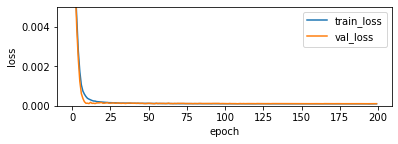

lr         2.3311762989647066e-06


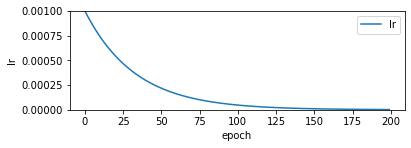

In [20]:
import matplotlib.pyplot as plt
import IPython.display as ipd

train_loss_plot, val_loss_plot = [], []
lr_plot = []
for epoch in range(num_epochs):
    # 학습율 저장    
    lr_plot.append(optimizer.param_groups[0]['lr'])
    # val set으로 평가
    val_epoch_loss = run_epoch(val_loader, training=False)
    # train set으로 학습
    train_epoch_loss = run_epoch(train_loader, training=True)
    # 평가값 저장
    train_loss_plot.append(train_epoch_loss)
    val_loss_plot.append(val_epoch_loss)

    # 애니메이션 형식으로 출력
    ipd.clear_output(wait=True)
    print('epoch' , epoch)
    print('train_loss', train_loss_plot[-1])
    print('val_loss  ', val_loss_plot[-1])
    show_loss_plot()
    print('lr        ', lr_plot[-1])
    show_lr_plot()
    
    # 가장 좋게 평가된 모델 저장
    if min(val_loss_plot)==val_epoch_loss:
        torch.save(model.state_dict(), save_path)

# Test

In [21]:
model.eval()
model.load_state_dict(torch.load(save_path, map_location=device))

<All keys matched successfully>

In [22]:
test_x = np.stack([data['x'] for data in test_data])
test_y = np.stack([data['y'] for data in test_data])
test_x.shape, test_y.shape

((1850, 60, 4), (1850, 4))

In [23]:
x = torch.tensor(test_x, dtype=torch.float32)
with torch.no_grad():
    pred = model(x.to(device))
    
pred = pred.cpu().detach().numpy()
pred = pred.reshape(370, 5).T
pred.shape

(5, 370)

In [24]:
def process_submission(index, pred, submission):
    for code_id, p in enumerate(pred):
        code = stock_list.reset_index().loc[code_id,'종목코드']
        submission.loc[index,code] = p * 1e6
    return submission

sample_submission = pd.read_csv(os.path.join(path,sample_name))
for i in range(5): # 11-01 ~ 11-05
    # csv에 한 행 넣기
    process_submission(i, pred[i], sample_submission)
    
sample_submission

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,28726.860881,34012.705088,57491.779327,153761.208057,95828.101039,14434.695244,46384.498477,81399.306655,97831.502557,...,45385.286212,49083.828926,73670.491576,31133.413315,27670.875192,51300.138235,303683.280945,268828.988075,27514.055371,15246.689320
1,2021-11-02,28719.872236,34085.184336,57458.370924,153258.800507,96348.881721,14423.549175,46414.211392,81572.353840,98094.493151,...,45431.777835,49195.438623,74041.143060,31276.196241,27574.956417,51264.718175,306609.749794,268800.795078,27460.008860,15165.388584
2,2021-11-03,28718.203306,34151.613712,57426.482439,152817.845345,96871.748567,14419.123530,46447.053552,81736.326218,98447.695374,...,45509.606600,49323.618412,74375.495315,31430.914998,27480.974793,51246.255636,309566.140175,268639.385700,27408.793569,15096.634626
3,2021-11-04,28725.028038,34201.592207,57397.961617,152407.541871,97481.787205,14414.101839,46496.689320,81900.089979,98832.920194,...,45599.132776,49474.000931,74690.416455,31584.233046,27381.792665,51222.056150,312407.076359,268261.164427,27352.616191,15034.556389
4,2021-11-05,28728.961945,34239.083529,57377.845049,152012.586594,98324.120045,14415.591955,46564.176679,82080.006599,99250.987172,...,45692.950487,49633.279443,74974.760413,31735.509634,27278.557420,51181.063056,315303.504467,267742.782831,27292.370796,14974.802732


In [25]:
# 예측값 저장
sample_submission.to_csv(f'{save_path}.csv',index=False)